(log-gaussian-cox-process)=
# Modeling spatial point patterns with a marked log-Gaussian Cox process

:::{post} May 31, 2022
:tags: cox process, latent gaussian process, nonparametric, spatial, count data
:category: intermediate
:author: Chrisopher Krapu, Chris Fonnesbeck
:::

## Introduction

The log-Gaussian Cox process (LGCP) is a probabilistic model of point patterns typically observed in space or time. It has two main components. First, an underlying *intensity* field $\lambda(s)$ of positive real values is modeled over the entire domain $X$ using an exponentially-transformed Gaussian process which constrains $\lambda$ to be positive. Then, this intensity field is used to parameterize a [Poisson point process](https://en.wikipedia.org/wiki/Poisson_point_process) which represents a stochastic mechanism for placing points in space. Some phenomena amenable to this representation include the incidence of cancer cases across a county, or the spatiotemporal locations of crime events in a city. Both spatial and temporal dimensions can be handled equivalently within this framework, though this tutorial only addresses data in two spatial dimensions.

In more formal terms, if we have a space $X$ and $A\subseteq X$, the distribution over the number of points $Y_A$ occurring within subset $A$ is given by
$$Y_A \sim Poisson\left(\int_A \lambda(s) ds\right)$$
and the intensity field is defined as
$$\log \lambda(s) \sim GP(\mu(s), K(s,s'))$$
where $GP(\mu(s), K(s,s'))$ denotes a Gaussian process with mean function $\mu(s)$ and covariance kernel $K(s,s')$ for a location $s \in X$. This is one of the simplest models of point patterns of $n$ events recorded as locations $s_1,...,s_n$ in an arbitrary metric space. In conjunction with a Bayesian analysis, this model can be used to answering questions of interest such as:
* Does an observed point pattern imply a statistically significant shift in spatial intensities?
* What would randomly sampled patterns with the same statistical properties look like?
* Is there a statistical correlation between the *frequency* and *magnitude* of point events?

In this notebook, we'll use a grid-based approximation to the full LGCP with PyMC to fit a model and analyze its posterior summaries. We will also explore the usage of a marked Poisson process, an extension of this model to account for the distribution of *marks* associated with each data point.

## Data

Our observational data concerns 231 sea anemones whose sizes and locations on the French coast were recorded. This data was taken from the [`spatstat` spatial modeling package in R](https://github.com/spatstat/spatstat) which is designed to address models like the LGCP and its subsequent refinements. The original source of this data is the textbook *Spatial data analysis by example* by Upton and Fingleton (1985) and a longer description of the data can be found there.

In [1]:
conda install -c conda-forge pymc rasterio geopandas shapely

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/wildfire

  added / updated specs:
    - geopandas
    - pymc
    - rasterio
    - shapely


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.5               |       h9c252e8_1          32 KB  conda-forge
    cfitsio-3.470              |       ha83d327_7         1.2 MB  conda-forge
    expat-2.7.0                |       h286801f_0         124 KB  conda-forge
    gdk-pixbuf-2.42.10         |       h969f7ef_2         579 KB
    geos-3.10.6                |       h303483a_0         1.1 MB  conda-forge
    geotiff-1.7.0              |       hcec61be_4         126 KB
    kealib-1.5.0               |       h3444380_2         144 KB
    libcxx-20.1.4              |       ha82da77_1         554 KB  conda-forge
    libexpat-2.7.0            

In [2]:
import warnings

from itertools import product



import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib import MatplotlibDeprecationWarning
from numpy.random import default_rng

warnings.filterwarnings(action="ignore", category=MatplotlibDeprecationWarning)

# Load Layouts

In [3]:
import os
import rasterio
from glob import glob
import geopandas as gpd
from rasterio.warp import transform_bounds
from shapely.geometry import Polygon
from pyproj import Transformer

In [4]:
# copy the layour tifs from a folder to a folder called sim2real_layout
import shutil

# Create the destination folder if it doesn't exist
os.makedirs("sim2real_layout", exist_ok=True)
for folder in os.listdir("WideDataset/"):
    # skip .DS_Store
    if folder == ".DS_Store":
        continue
    # open the "Fuel_Map" subfolder and copy the Canopy_Base_Height.tif file
    shutil.copy(f"WideDataset/{folder}/Vegetation_Map/Existing_Vegetation_Cover.tif", f"sim2real_layout/{folder}_Existing_Vegetation_Cover.tif")

In [5]:
def decimal_to_dms(decimal):
    degrees = int(decimal)
    remaining = abs(decimal) - abs(degrees)
    minutes = int(remaining * 60)
    seconds = (remaining * 60 - minutes) * 60
    return degrees, minutes, seconds

def print_decimal_to_dms(decimal_long, decimal_lat, extra_text = ''):
    degrees_lat = int(decimal_lat)
    remaining_lat = abs(decimal_lat) - abs(degrees_lat)
    minutes_lat = int(remaining_lat * 60)
    seconds_lat = (remaining_lat * 60 - minutes_lat) * 60
    degrees_long = int(decimal_long)
    remaining_long = abs(decimal_long) - abs(degrees_long)
    minutes_long = int(remaining_long * 60)
    seconds_long = (remaining_long * 60 - minutes_long) * 60
    print(f"{extra_text}: {abs(degrees_lat)}° {minutes_lat}' {seconds_lat:.4f}\" {'S' if degrees_lat < 0 else 'N'} {abs(degrees_long)}° {minutes_long}' {seconds_long:.4f}\" {'W' if degrees_long < 0 else 'E'}")


# Path to the folder containing .tif files
folder_path = "sim2real_layout"

# Get a list of all .tif files in the folder
tif_files = glob(os.path.join(folder_path, "*.tif"))

layout_list = []
widths = []
heights = []
names = []

# Open each .tif file
for tif_file in tif_files:
    with rasterio.open(tif_file) as dataset:

        
        # get the file name without the path
        file_name = os.path.basename(tif_file)  # '0004_Elevation.tif'
        identifier = "_".join(file_name.split('_')[:2])

        # extract the resolution, check it is 30
        x_resolution = dataset.transform[0]
        y_resolution = -dataset.transform[4]
        assert x_resolution == y_resolution == 30, f"Resolution is not the same: {x_resolution} != {y_resolution}"

        # technique 1: using the bounds
        x_min = dataset.bounds[0]
        x_max = dataset.bounds[2]
        y_min = dataset.bounds[1]
        y_max = dataset.bounds[3]

        transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)
        lat_top_left, lon_top_left = transformer.transform(x_min, y_max)
        lat_top_right, lon_top_right = transformer.transform(x_max, y_max)
        lat_bottom_left, lon_bottom_left = transformer.transform(x_min, y_min)
        lat_bottom_right, lon_bottom_right = transformer.transform(x_max, y_min)


        # technique 2: using the pixel 0,0 : SAME AS 1 BUT OFF PY HALF A PIXEL
        # x_tl_pixel, y_tl_pixel = rasterio.transform.xy(dataset.transform, 0, 0)
        # x_bl_pixel, y_bl_pixel = rasterio.transform.xy(dataset.transform, dataset.height - 1, 0)
        # x_br_pixel, y_br_pixel = rasterio.transform.xy(dataset.transform, dataset.height - 1, dataset.width - 1)
        # x_tr_pixel, y_tr_pixel = rasterio.transform.xy(dataset.transform, 0, dataset.width - 1)

        # lat_tl_pixel, long_tl_pixel = transformer.transform(x_tl_pixel, y_tl_pixel)
        # lat_bl_pixel, long_bl_pixel = transformer.transform(x_bl_pixel, y_bl_pixel)
        # lat_br_pixel, long_br_pixel = transformer.transform(x_br_pixel, y_br_pixel)
        # lat_tr_pixel, long_tr_pixel = transformer.transform(x_tr_pixel, y_tr_pixel)


        # technique 3 : using the boundaries transformation : THIS IS REEAAAALY OFF. it's what we were using before. This somehow creates the lasrgest rectangle containing the raster (that is a rotated rectangle).
        # minx_boundary, miny_boundary, maxx_boundary, maxy_boundary = transform_bounds(dataset.crs, 'EPSG:4326', *dataset.bounds)

        # lat_tl_boundary, long_tl_boundary = minx_boundary, maxy_boundary
        # lat_bl_boundary, long_bl_boundary = minx_boundary, miny_boundary
        # lat_br_boundary, long_br_boundary = maxx_boundary, miny_boundary
        # lat_tr_boundary, long_tr_boundary = maxx_boundary, maxy_boundary

        # print the 3 different representations
        # if identifier == "0005_00725":
        #     print("top left:")
        #     print_decimal_to_dms(lat_top_left, lon_top_left)
        #     print_decimal_to_dms(lat_tl_pixel, long_tl_pixel)
        #     print_decimal_to_dms(lat_tl_boundary, long_tl_boundary)

        #     print("top right:")
        #     print_decimal_to_dms(lat_top_right, lon_top_right)
        #     print_decimal_to_dms(lat_tr_pixel, long_tr_pixel)
        #     print_decimal_to_dms(lat_tr_boundary, long_tr_boundary)

        #     print("bottom left:")
        #     print_decimal_to_dms(lat_bottom_left, lon_bottom_left)
        #     print_decimal_to_dms(lat_bl_pixel, long_bl_pixel)
        #     print_decimal_to_dms(lat_bl_boundary, long_bl_boundary)

        #     print("bottom right:")
        #     print_decimal_to_dms(lat_bottom_right, lon_bottom_right)
        #     print_decimal_to_dms(lat_br_pixel, long_br_pixel)
        #     print_decimal_to_dms(lat_br_boundary, long_br_boundary)        


        # Create the polygon using the transformed bounds
        polygon = Polygon((
            (lat_top_left, lon_top_left),
            (lat_top_right, lon_top_right),
            (lat_bottom_right, lon_bottom_right),
            (lat_bottom_left, lon_bottom_left),
            (lat_top_left, lon_top_left)  # close the polygon
        ))

        layout_list.append({
            'identifier': identifier,
            'height': dataset.height,
            'width': dataset.width,
            'geometry': polygon
        })


        widths.append(dataset.width)
        heights.append(dataset.height)
        names.append(identifier)

sorted_indices = np.argsort(widths)[::-1]
widths = np.array(widths)[sorted_indices]
heights = np.array(heights)[sorted_indices]
names = np.array(names)[sorted_indices]
filtered_layout_list = [layout_list[i] for i in sorted_indices]

n_small_layouts = len(widths[widths < 500])
n_medium_layouts = len(widths[(widths >= 500) & (widths < 1000)])
n_large_layouts = len(widths[widths >= 1000])

small_layouts = filtered_layout_list[:n_small_layouts]
medium_layouts = filtered_layout_list[n_small_layouts:n_small_layouts + n_medium_layouts]
large_layouts = filtered_layout_list[n_small_layouts + n_medium_layouts:]












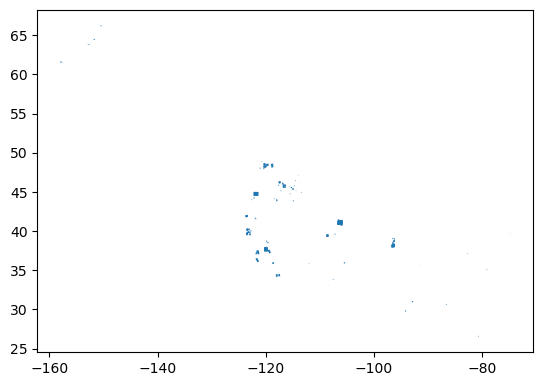

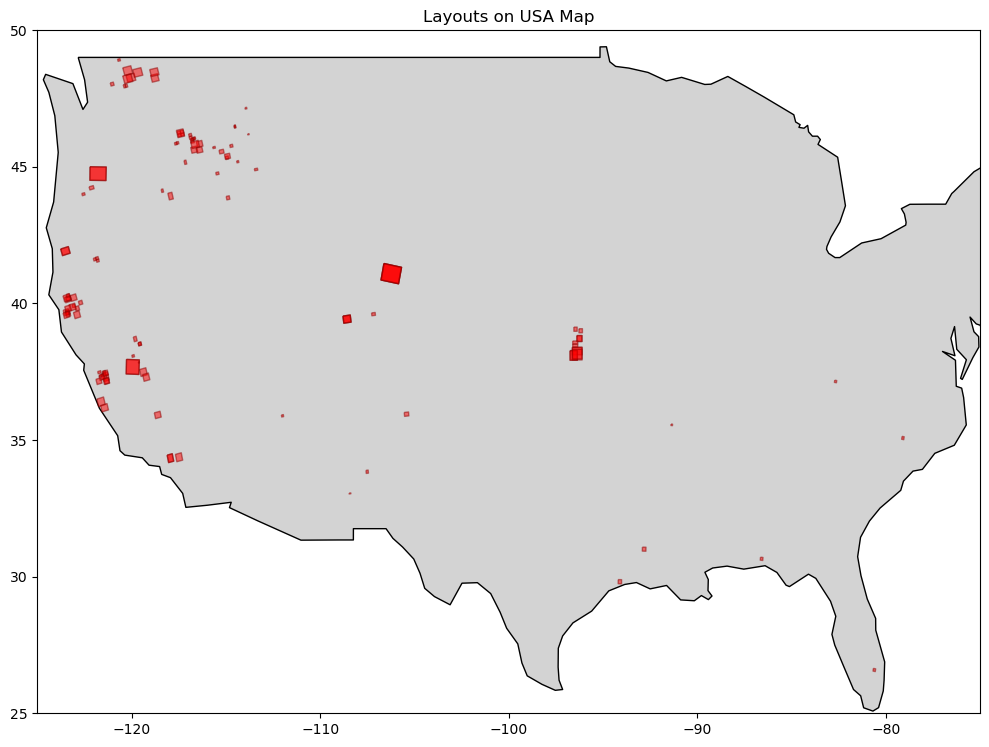

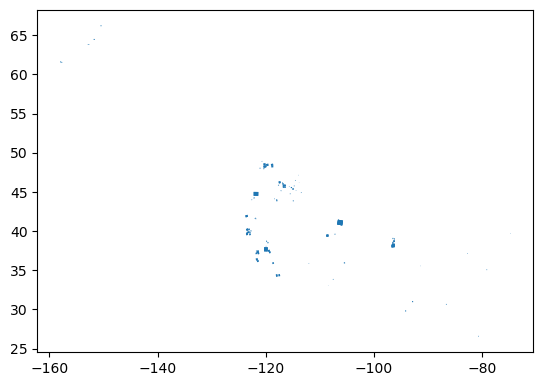

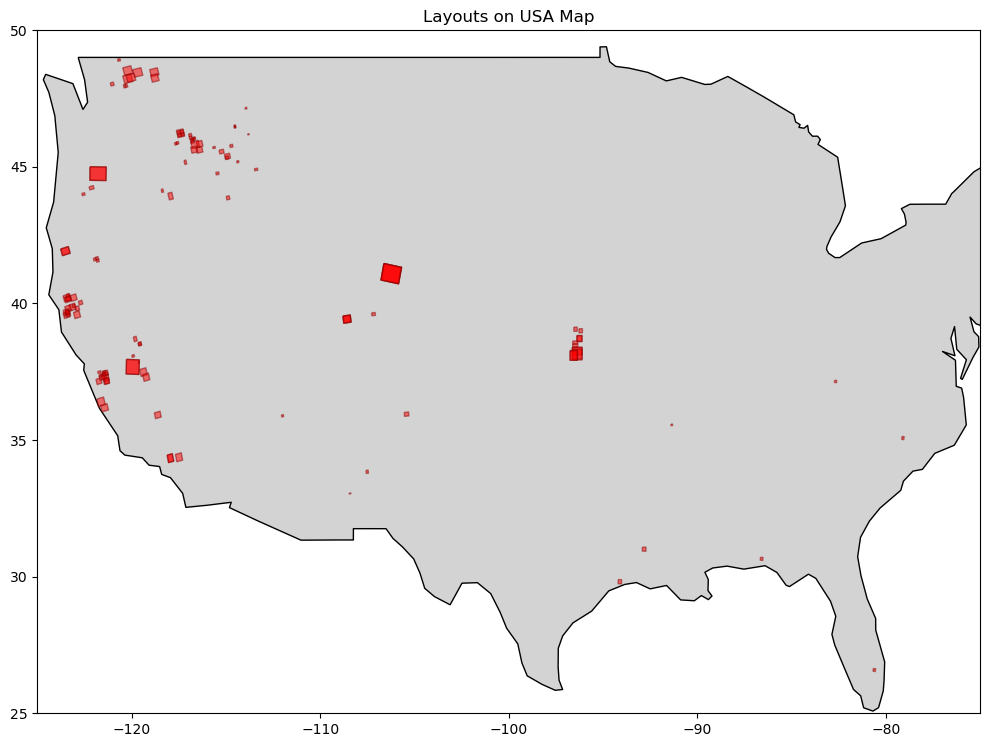

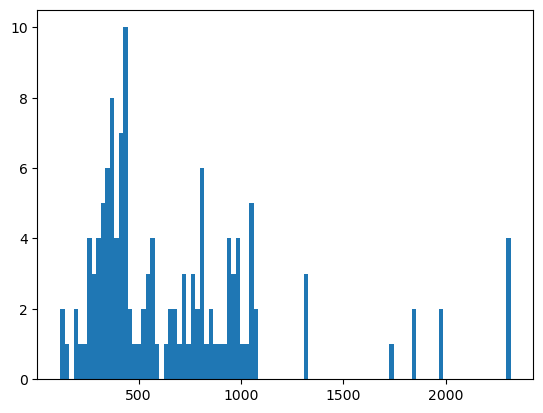

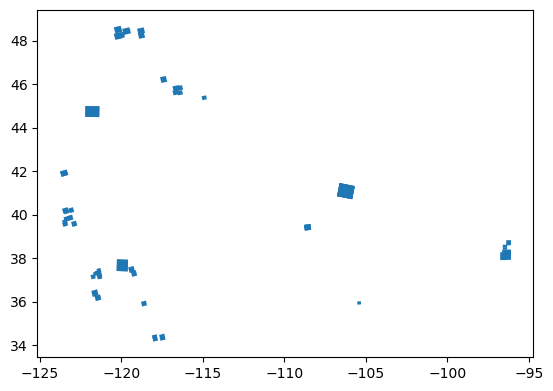

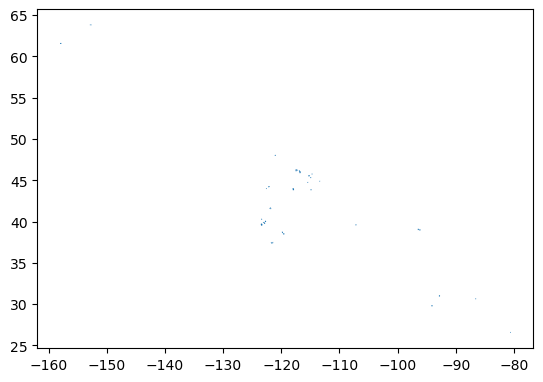

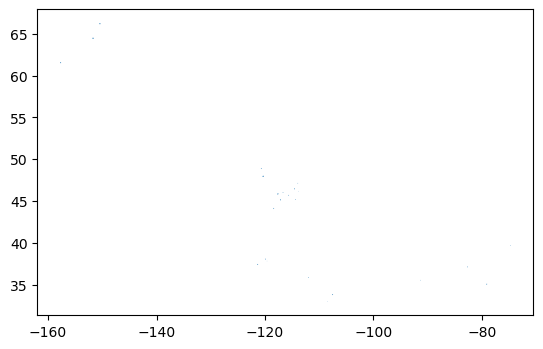

In [6]:
gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")
# print the shapes on the map
gdf.plot()
plt.show()

gdf = gpd.GeoDataFrame(layout_list, geometry='geometry', crs="EPSG:4326")

world = gpd.read_file("naturalearth_lowres/naturalearth_lowres.shp")
usa = world[world.name == 'United States of America']

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='darkred')

# set axis limits
ax.set_xlim(-125, -75)
ax.set_ylim(25, 50)

ax.set_title("Layouts on USA Map")
plt.tight_layout()
plt.show()


gdf = gpd.GeoDataFrame(filtered_layout_list, geometry='geometry', crs="EPSG:4326")
# print the shapes on the map
gdf.plot()
plt.show()

gdf = gpd.GeoDataFrame(filtered_layout_list, geometry='geometry', crs="EPSG:4326")

world = gpd.read_file("naturalearth_lowres/naturalearth_lowres.shp")
usa = world[world.name == 'United States of America']

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 8))
usa.plot(ax=ax, color='lightgrey', edgecolor='black')
gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='darkred')

# set axis limits
ax.set_xlim(-125, -75)
ax.set_ylim(25, 50)

ax.set_title("Layouts on USA Map")
plt.tight_layout()
plt.show()

# print histogram of polygon widths
plt.hist(heights, bins=100)
plt.show()

# small layouts
small_layouts_gdf = gpd.GeoDataFrame(small_layouts, geometry='geometry', crs="EPSG:4326")
small_layouts_gdf.plot()
plt.show()

# medium layouts
medium_layouts_gdf = gpd.GeoDataFrame(medium_layouts, geometry='geometry', crs="EPSG:4326")
medium_layouts_gdf.plot()
plt.show()

# large layouts
large_layouts_gdf = gpd.GeoDataFrame(large_layouts, geometry='geometry', crs="EPSG:4326")
large_layouts_gdf.plot()
plt.show()














# FPA-FOD – Fire Program Analysis Fire Occurrence Database (USA)

What it has: 2+ million ignition points from 1992 to present (US), with cause, size, discovery time

Use for risk: Target variable (ignition), feature engineering (cause), spatiotemporal patterns

Link: https://www.fs.usda.gov/rds/archive/Catalog/RDS-2013-0009.5

In [7]:
fires_gdf = gpd.read_file("FPA_FOD_20210617.gpkg")

/opt/anaconda3/envs/wildfire/lib/python3.11/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'FPA_FOD_20210617.gpkg': 'Fires' (default), 'NWCG_UnitIdActive_20200123'. Specify layer parameter to avoid this warning.
  result = read_func(
/opt/anaconda3/envs/wildfire/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Non-conformant content for record 1 in column DISCOVERY_DATE, 2005-02-02T00:00:00.0Z, successfully parsed
  return ogr_read(


In [8]:
fires_gdf = fires_gdf.to_crs("EPSG:4326")

In [9]:
fires_gdf.DISCOVERY_DATE

0         2005-02-02 00:00:00+00:00
1         2004-05-12 00:00:00+00:00
2         2004-05-31 00:00:00+00:00
3         2004-06-28 00:00:00+00:00
4         2004-06-28 00:00:00+00:00
                     ...           
2166748   2016-10-18 00:00:00+00:00
2166749   2016-10-22 00:00:00+00:00
2166750   2017-04-02 00:00:00+00:00
2166751   2017-11-30 00:00:00+00:00
2166752   2015-07-20 00:00:00+00:00
Name: DISCOVERY_DATE, Length: 2166753, dtype: datetime64[ms, UTC]

## Spatial Join

In [10]:
# Spatial join: find which points fall into which polygons
joined = gpd.sjoin(fires_gdf, gdf, how='inner', predicate='within')
joined_small = gpd.sjoin(fires_gdf, small_layouts_gdf, how='inner', predicate='within')
joined_medium = gpd.sjoin(fires_gdf, medium_layouts_gdf, how='inner', predicate='within')
joined_large = gpd.sjoin(fires_gdf, large_layouts_gdf, how='inner', predicate='within')

# Count points per polygon
counts = joined.groupby('identifier').size().reset_index(name='fire_count')
counts_small = joined_small.groupby('identifier').size().reset_index(name='fire_count')
counts_medium = joined_medium.groupby('identifier').size().reset_index(name='fire_count')
counts_large = joined_large.groupby('identifier').size().reset_index(name='fire_count')


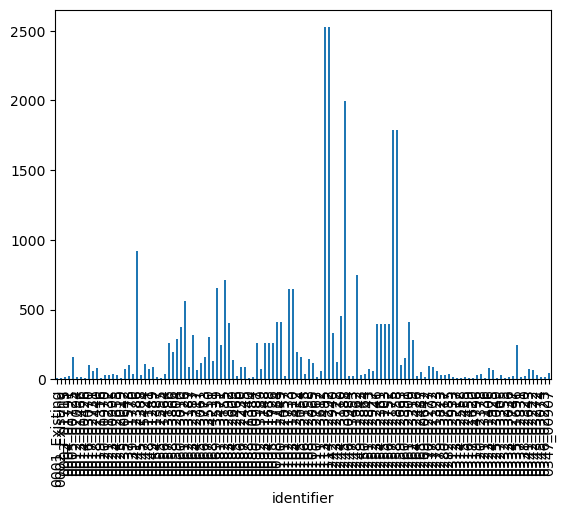

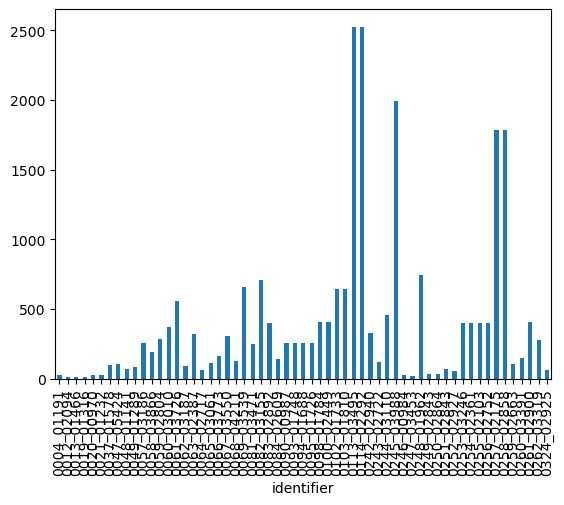

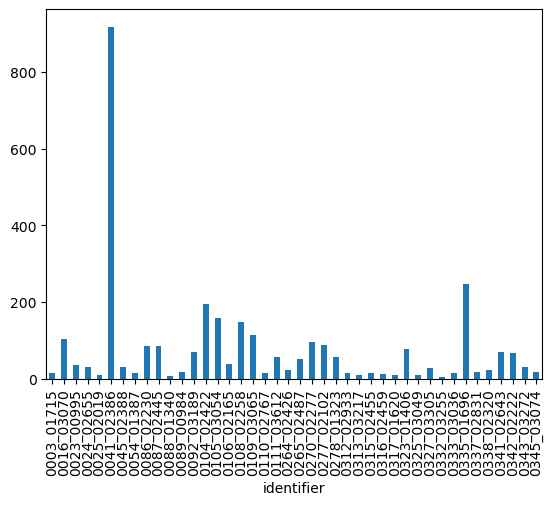

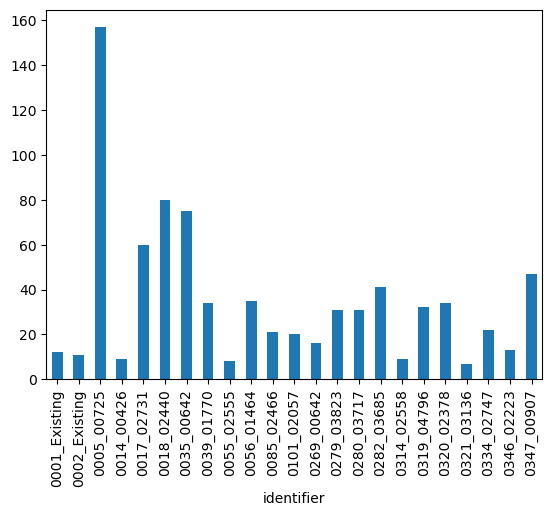

In [11]:
# plot counts per polygon as a bar plot
counts.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()

# plot counts per polygon as a bar plot
counts_small.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()

# plot counts per polygon as a bar plot
counts_medium.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()

# plot counts per polygon as a bar plot
counts_large.plot(kind='bar', x='identifier', y='fire_count', legend=False)
plt.show()

# # print how many have fire_count > 100
# print(len(counts[counts['fire_count'] > 10]))

# # print names of the polygons with fire_count <10
# print(counts[counts['fire_count'] < 100]['identifier'].unique())




<Axes: xlabel='DISCOVERY_DATE'>

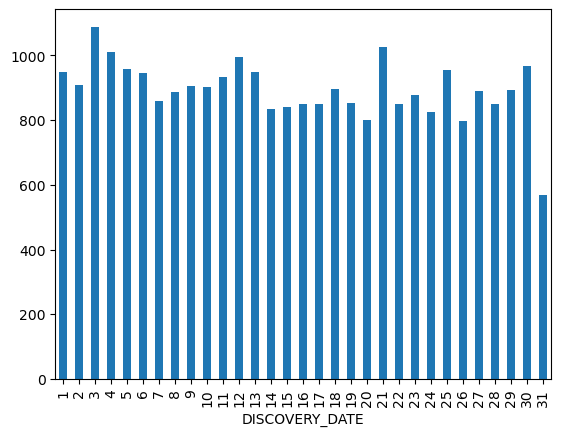

In [12]:
joined.DISCOVERY_DATE.dt.day.value_counts().sort_index(ascending=True).plot(kind='bar')

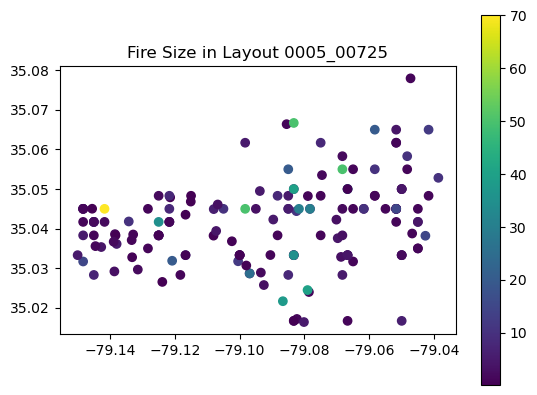

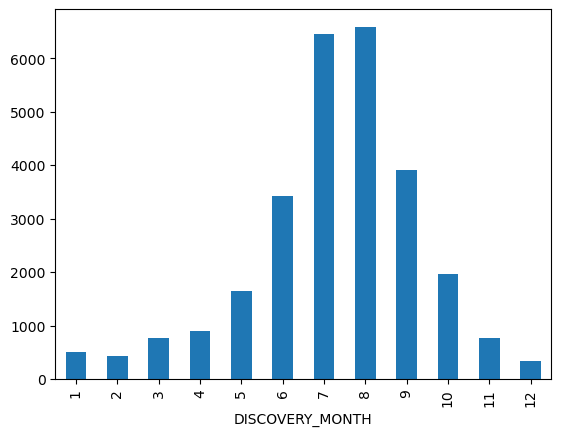

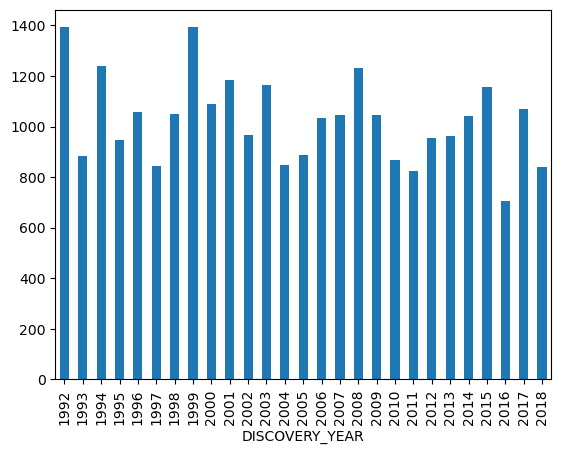

In [13]:
layout = '0005_00725'

joined[joined['identifier'] == layout].plot(column='FIRE_SIZE', cmap='viridis', legend=True)
plt.title(f'Fire Size in Layout {layout}')

plt.show()

# histogram plot of the discovery month (from the timestamp)
joined['DISCOVERY_MONTH'] = joined['DISCOVERY_DATE'].dt.month
joined['DISCOVERY_MONTH'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show()

# plot the timeline of fire events in the layout as a histogram of the discovery year
joined['DISCOVERY_YEAR'] = joined['DISCOVERY_DATE'].dt.year
joined['DISCOVERY_YEAR'].value_counts().sort_index(ascending=True).plot(kind='bar')
plt.show()

# plot the timeline of fire events in the layout as a histogram of the discovery month and year



In [14]:
# Export one layout
joined[joined['identifier'] == layout][['LATITUDE','LONGITUDE','FIRE_SIZE']].to_csv(f"layout_{layout}_fire_data.csv", index=False)

# Log Gaussian Cox Process

In [15]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [16]:
data = pd.read_csv(f"layout_{layout}_fire_data.csv")
n = data.shape[0]

This dataset has coordinates and discrete mark values for each anemone. While these marks are integers, for the sake of simplicity we will model these values as continuous in a later step.

In [16]:
data.head(3)

,LATITUDE,LONGITUDE,FIRE_SIZE
0,35.021667,-79.086667,38.0
1,35.042270,-79.070150,3.0
2,35.037580,-79.069740,4.0


In [17]:
data.rename(
    columns={
        "LATITUDE": "y",
        "LONGITUDE": "x",
        "FIRE_SIZE": "marks",
    },
    inplace=True,
)

Let's take a look at this data in 2D space:

In [18]:
# # Shift coordinates so that min is 0
# data["x"] = data["x"] - data["x"].min()
# data["y"] = data["y"] - data["y"].min()

# data["x"] = data["x"] / data["x"].max() * 280
# data["y"] = data["y"] / data["y"].max() * 180

# Resulting (x, y) starts from 0
grid_coords = data[["x", "y"]].values

((-79.13326758618935, 35.134704136936215), (-79.02054669405658, 35.11831993158381), (-79.0445816506189, 35.0106662463607), (-79.15714983894838, 35.02702886055301), (-79.13326758618935, 35.134704136936215))
Latitude: 35° 0' 38.3985" N
Longitude: 79° 9' 25.7394" W
Latitude: 35° 8' 4.9349" N
Longitude: 79° 1' 13.9681" W
35.134704136936215
x_distance, y_distance 6287.42342026066 27733.43038194813


'\nLatitude, Longitude: 35.13454852501319, -79.13313349653575\nLatitude: 35° 8\' 4.3747" N\nLongitude: 79° 7\' 59.2806" W\nLatitude: 35° 1\' 28.0051" N\nLongitude: 79° 1\' 13.6322" W\n'

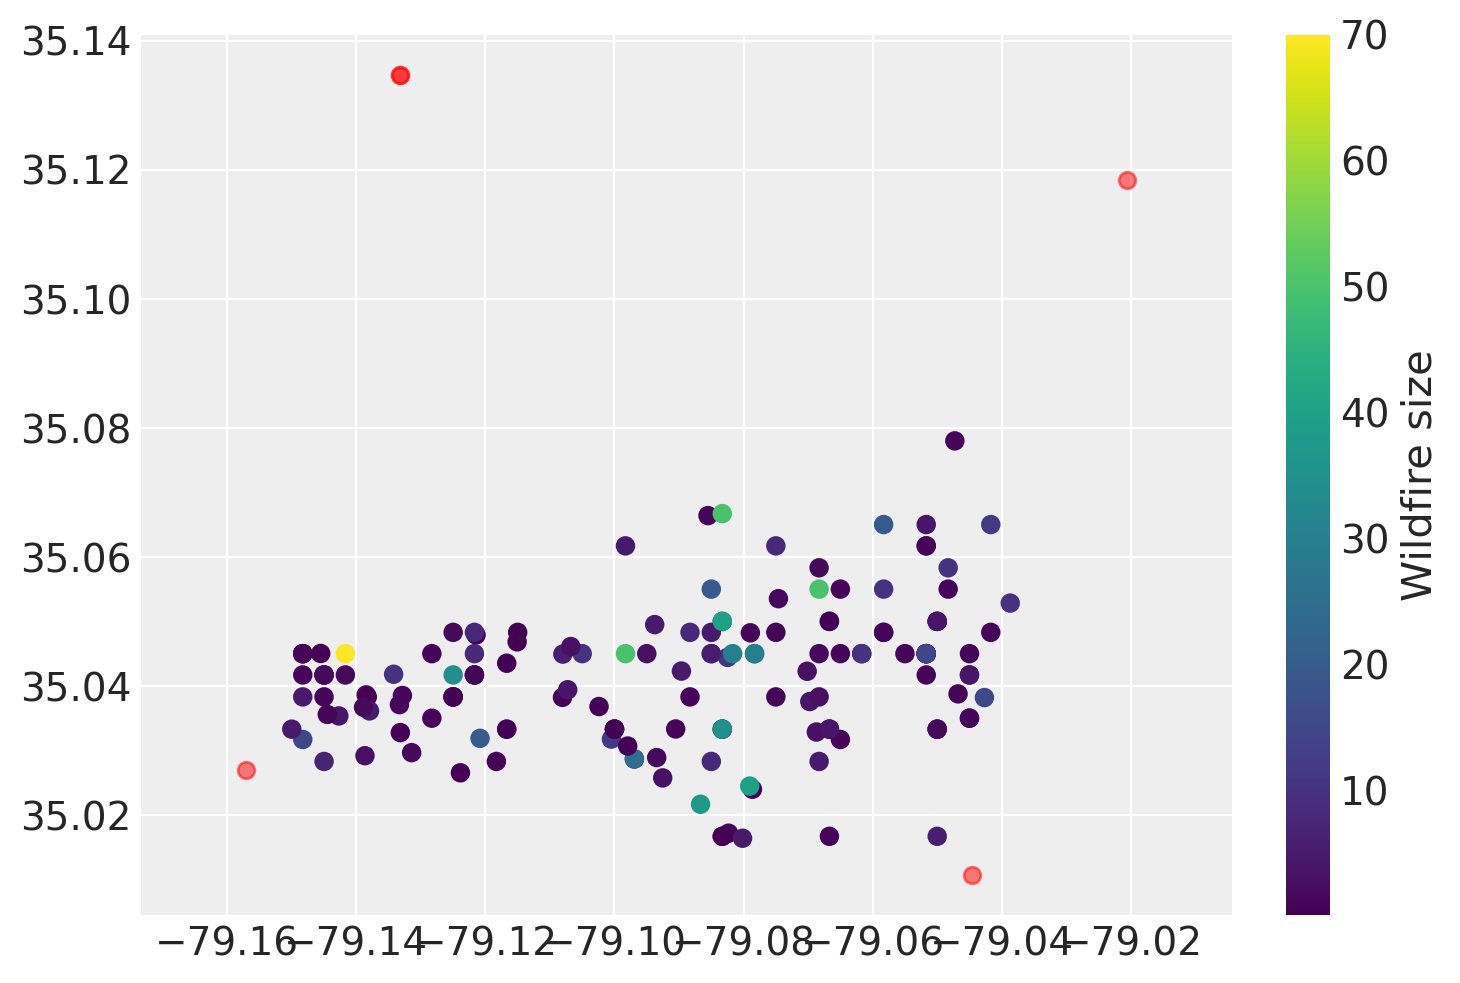

In [19]:
from shapely.geometry import Polygon, mapping, Point
layout_dict = {layout_name: layout_object for layout_name, layout_object in zip(names, filtered_layout_list)}

plt.scatter(data["x"], data["y"], c=data["marks"])
plt.colorbar(label="Wildfire size")
plt.axis("equal");
# plot boundaries of the layout
print(   mapping(layout_dict[layout]['geometry'])['coordinates'][0]    )

x_s = [ coord[0] for coord in mapping(layout_dict[layout]['geometry'])['coordinates'][0] ]
y_s = [ coord[1] for coord in mapping(layout_dict[layout]['geometry'])['coordinates'][0] ]

max_x = max(x_s)
min_x = min(x_s)
max_y = max(y_s)
min_y = min(y_s)

# prett print degree minutes seconds of the min and max x and y
lat_deg, lat_min, lat_sec = decimal_to_dms(min_y)
lon_deg, lon_min, lon_sec = decimal_to_dms(min_x)
print(f"Latitude: {abs(lat_deg)}° {lat_min}' {lat_sec:.4f}\" {'S' if lat_deg < 0 else 'N'}")
print(f"Longitude: {abs(lon_deg)}° {lon_min}' {lon_sec:.4f}\" {'W' if lon_deg < 0 else 'E'}")

lat_deg, lat_min, lat_sec = decimal_to_dms(max_y)
lon_deg, lon_min, lon_sec = decimal_to_dms(max_x)
print(f"Latitude: {abs(lat_deg)}° {lat_min}' {lat_sec:.4f}\" {'S' if lat_deg < 0 else 'N'}")
print(f"Longitude: {abs(lon_deg)}° {lon_min}' {lon_sec:.4f}\" {'W' if lon_deg < 0 else 'E'}")




def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1


plt.scatter(x_s, y_s, c='red', alpha=0.5)
plt.axis("equal");


# project the coordinates to crs for distance calculation
points = [Point(x, y) for x, y in zip(x_s, y_s)]
gdf1 = gpd.GeoDataFrame(index=[0], geometry=[Point(min(x_s), min(y_s))], crs="EPSG:4326")
gdf2 = gpd.GeoDataFrame(index=[0], geometry=[Point(max(x_s), max(y_s))], crs="EPSG:4326")

# Determine the UTM zone
utm_zone = get_utm_zone(y_s[0])
print(y_s[0])

# Reproject to the corresponding UTM zone
gdf1 = gdf1.to_crs(epsg=32600 + utm_zone)
gdf2 = gdf2.to_crs(epsg=32600 + utm_zone)

x_distance = abs(gdf1.geometry.x[0] - gdf2.geometry.x[0])
y_distance = abs(gdf1.geometry.y[0] - gdf2.geometry.y[0])
print("x_distance, y_distance", x_distance, y_distance)



"""
Latitude, Longitude: 35.13454852501319, -79.13313349653575
Latitude: 35° 8' 4.3747" N
Longitude: 79° 7' 59.2806" W
Latitude: 35° 1' 28.0051" N
Longitude: 79° 1' 13.6322" W
"""


In [20]:
type(layout_dict[layout]['geometry'])

shapely.geometry.polygon.Polygon

The 'marks' column indicates the size of each anemone. If we were to model both the marks and the spatial distribution of points, we would be modeling a *marked Poisson point process*. Extending the basic point pattern model to include this feature is the second portion of this notebook.

While there are multiple ways to conduct inference, perhaps the  simplest way is to slice up our domain $X$ into many small pieces $A_1, A_2,...,A_M$ and fix the intensity field to be constant within each subset. Then, we will treat the number of points within each $A_j$ as a Poisson random variable such that $Y_j \sim Poisson(\lambda_j)$. and we also consider the $\log{\lambda_1}...,\log{\lambda_M}$ variables as a single draw from a Gaussian process.

The code below splits up the domain into grid cells, counts the number of points within each cell and also identifies its centroid.

           y          x  marks
0  35.021667 -79.086667   38.0
1  35.042270 -79.070150    3.0
2  35.037580 -79.069740    4.0
3  35.023990 -79.078630    1.0
4  35.029660 -79.131430    2.0
-79.13326758618935 [ 3.26727224e-04 -4.74904503e-05] 35.134704136936215 [-5.85349332e-05 -2.63909991e-04]
data min and max:
-79.15 -79.03868333 35.0164 35.07796666
bounding box:
-79.13326758618935 35.134704136936215 -79.04442894681561 35.01064465520061


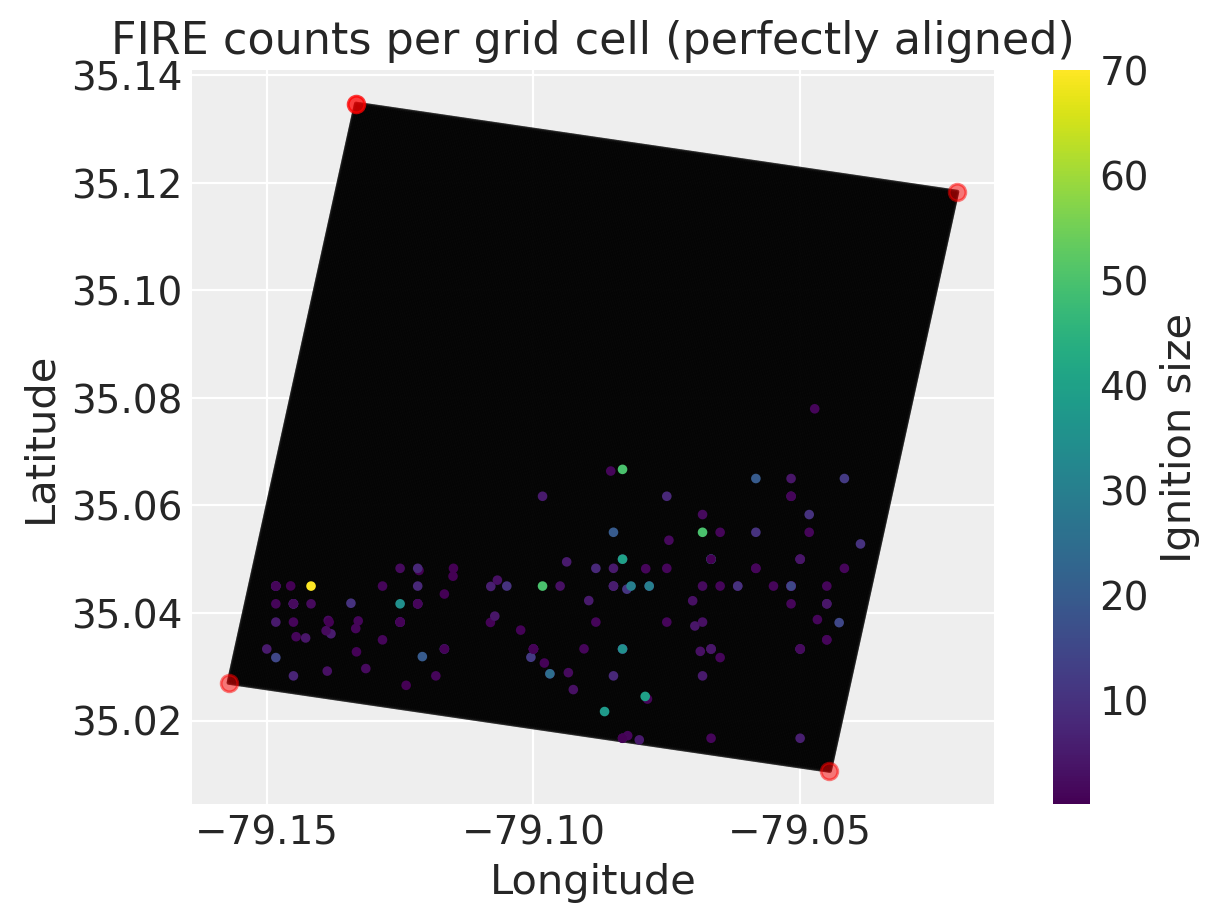

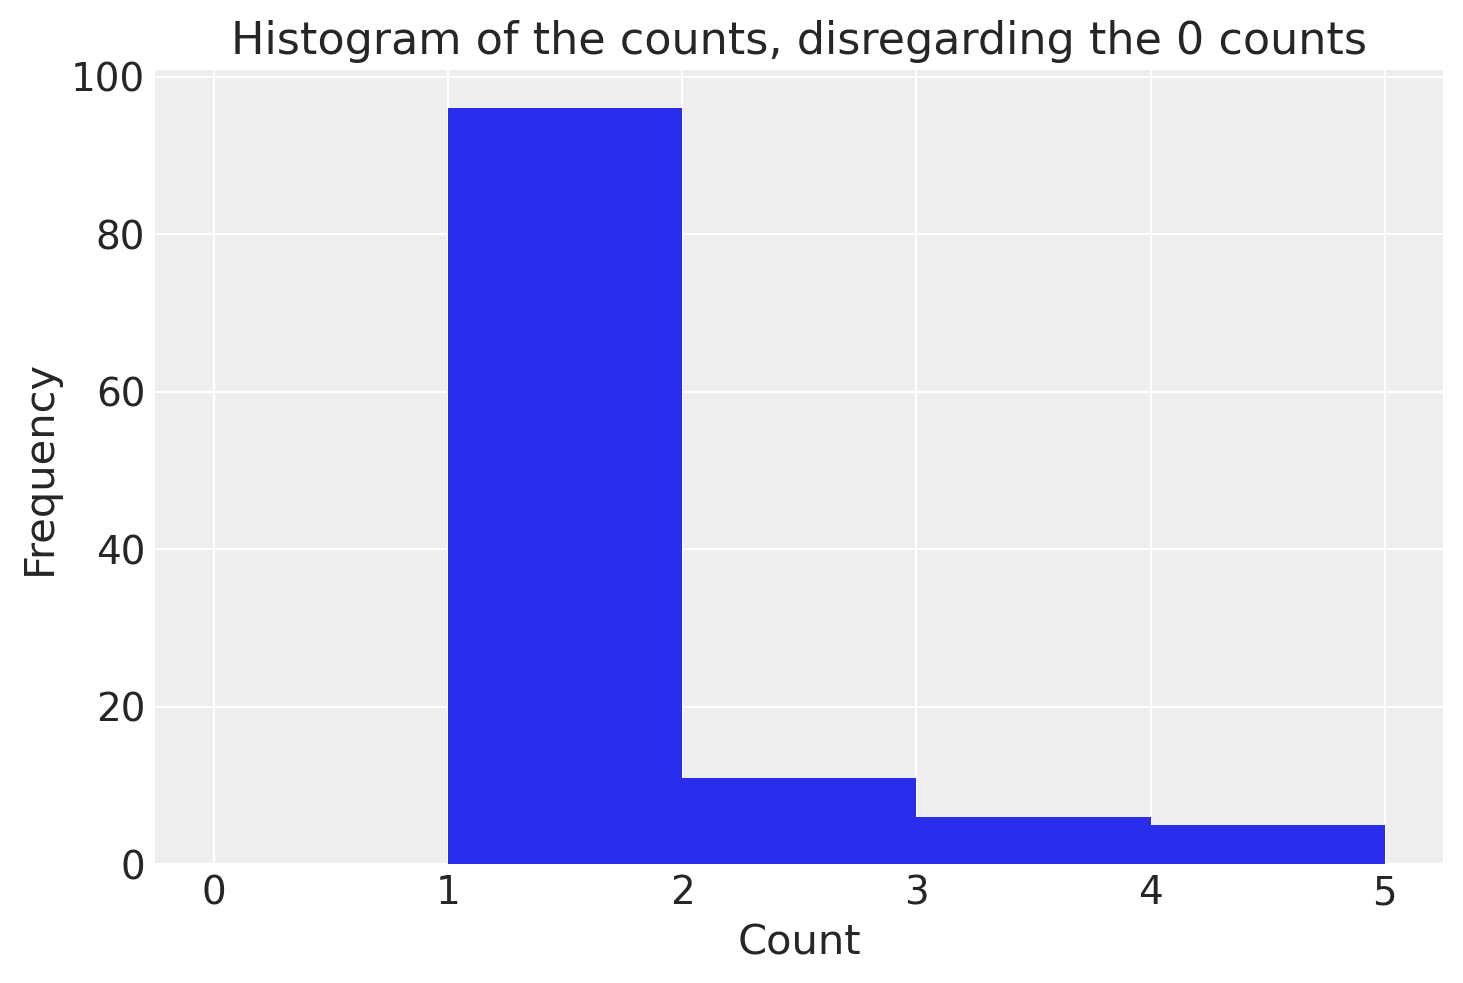

In [21]:
# open a scenario assoc to this layout

# import requred modules
import sys
import os

def return_first_scenario(path):
    chosen_subfolder = None
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir() and entry.name != '.DS_Store':
                chosen_subfolder = entry.name
                break
    if chosen_subfolder is None:
        raise ValueError("No subfolder found")
    return chosen_subfolder


# Add code to path
module_path = os.path.abspath(".") + "/code"
if module_path not in sys.path:
    sys.path.append(module_path)

from dataset import load_scenario

path = f"./WideDataset/{layout}/Satellite_Images_Mask/"

scenario = load_scenario(f"{path}{return_first_scenario(path)}", extension = ".jpg")

# asset width and heigh match with scenarios
assert layout_dict[layout]['width'] == scenario[0].shape[1], f"width does not match: {layout_dict[layout]['width']} != {scenario[0].shape[1]}"
assert layout_dict[layout]['height'] == scenario[0].shape[0], f"height does not match: {layout_dict[layout]['height']} != {scenario[0].shape[0]}"


# --- Parameters ---
cells_x = layout_dict[layout]['width'] / 1
cells_y = layout_dict[layout]['height'] / 1

assert round(cells_x) == cells_x, f"cells_x is not an integer: {cells_x}"
assert round(cells_y) == cells_y, f"cells_y is not an integer: {cells_y}"

cells_x = round(cells_x)
cells_y = round(cells_y)

# --- Define rectangle corners ---
P0 = np.array([x_s[0], y_s[0]])  # Reference corner
P1 = np.array([x_s[1], y_s[1]])  # Adjacent corner (defines one edge)
P3 = np.array([x_s[3], y_s[3]])  # Other adjacent corner

vec_u = (P1 - P0) / cells_x  # Step along one edge
vec_v = (P3 - P0) / cells_y  # Step along adjacent edge

# dot product of vec_u and vec_v: check it is a rectangle (so that all cells have the same area)
dot_product = np.dot(vec_u, vec_v)
assert dot_product <= 1e-4, "vec_u and vec_v are not perpendicular"

area_per_cell = np.linalg.norm(vec_u) * np.linalg.norm(vec_v)

# --- Plotting ---
plt.figure(figsize=(6, 4.5))

# Plot grid lines parallel to vec_v (vertical grid lines)
for i in range(cells_x + 1):
    start = P0 + i * vec_u
    end = start + cells_y * vec_v
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', alpha=0.5)

# Plot grid lines parallel to vec_u (horizontal grid lines)
for j in range(cells_y + 1):
    start = P0 + j * vec_v
    end = start + cells_x * vec_u
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', alpha=0.5)

# Plot boundary points
plt.scatter(x_s, y_s, c='red', alpha=0.5, zorder=3)

# compute cell counts
print(data.head())
print(P0[0], vec_u, P0[1], vec_v)
print("data min and max:")
print(data["x"].min(), data["x"].max(), data["y"].min(), data["y"].max())
print("bounding box:")
print(P0[0], P0[1], P0[0] + cells_x * vec_u[0] + cells_y * vec_v[0], P0[1] + cells_x * vec_u[1] + cells_y * vec_v[1])

import numpy as np
from collections import defaultdict

# --- Precompute inverse lattice matrix ---
M = np.column_stack((vec_u, vec_v))  # 2x2 matrix: [vec_u | vec_v]
M_inv = np.linalg.inv(M)  # Inverse matrix

# --- Initialize counts ---
cell_counts = np.zeros((cells_x, cells_y), dtype=int)

# --- Process all points efficiently ---
points = data[['x', 'y']].to_numpy()  # shape (N, 2)
relative_points = points - P0  # shift to origin

# Compute lattice coordinates [alpha, beta] for all points
lattice_coords = relative_points @ M_inv.T  # shape (N, 2)

# Floor to get integer cell indices (i, j)
i_indices = np.floor(lattice_coords[:, 0]).astype(int)
j_indices = np.floor(lattice_coords[:, 1]).astype(int)

# Filter points that fall within the grid bounds
valid_mask = (i_indices >= 0) & (i_indices < cells_x) & (j_indices >= 0) & (j_indices < cells_y)
valid_i = i_indices[valid_mask]
valid_j = j_indices[valid_mask]

# Count points per cell
for i, j in zip(valid_i, valid_j):
    cell_counts[i, j] += 1

# compute the centroids of the cells
centroids = np.array([[i * vec_u[0] + j * vec_v[0], i * vec_u[1] + j * vec_v[1]] for i in range(cells_x) for j in range(cells_y)])

# Optional: 
#cell_counts_flat = cell_counts.flatten()

# check that every point belongs to a cell
assert sum(cell_counts.flatten()) == len(data)

# Plot data points
plt.scatter(data["x"], data["y"], c=data["marks"], s=6, cmap='viridis', zorder=2)
plt.title("FIRE counts per grid cell (perfectly aligned)")
plt.colorbar(label="Ignition size")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show() 

# display histogram of the counts, disregarding the 0 counts
plt.hist(cell_counts[cell_counts > 0], bins=range(max(cell_counts[cell_counts > 0]) + 1))
plt.title("Histogram of the counts, disregarding the 0 counts")
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.show()





We can see that all of the counts are fairly low and range from zero to five. With all of our data prepared, we can go ahead and start writing out our probabilistic model in PyMC. We are going to treat each of the per-cell counts $Y_1,...Y_M$ above as a Poisson random variable.

# Inference

Our first step is to place prior distributions over the high-level parameters for the Gaussian process. This includes the length scale $\rho$ for the covariance function and a constant mean $\mu$ for the GP.

In [22]:
with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", sigma=3)
    rho = pm.Uniform("rho", lower=25, upper=300)
    variance = pm.InverseGamma("variance", alpha=1, beta=1)
    cov_func = variance * pm.gp.cov.Matern52(2, ls=rho)
    mean_func = pm.gp.mean.Constant(mu)

Next, we transform the Gaussian process into a positive-valued process via `pm.math.exp` and use the area per cell to transform the intensity function $\lambda(s)$ into rates $\lambda_i$ parameterizing the Poisson likelihood for the counts within cell $i$.

In [7]:
# compute the centroids of the cells
centroids = np.array([[i * vec_u[0] + j * vec_v[0], i * vec_u[1] + j * vec_v[1]] for i in range(cells_x) for j in range(cells_y)])

with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)

    log_intensity = gp.prior("log_intensity", X=centroids)
    intensity = pm.math.exp(log_intensity)
    rates = intensity * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

NameError: name 'np' is not defined

In [24]:
!clang --version

Apple clang version 16.0.0 (clang-1600.0.26.6)
Target: arm64-apple-darwin24.3.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


With the model fully specified, we can start sampling from the posterior using the default NUTS sampler. I'll also tweak the target acceptance rate to reduce the number of divergences.

In [ ]:
# with lgcp_model:
#     trace = pm.sample(1000, tune=2000, target_accept=0.95)

with lgcp_model:
    trace = pm.sample(1000, tune=2000, cores=1, chains=2, target_accept=0.95)


NameError: name 'lgcp_model' is not defined

In [25]:
import pymc as pm
import random
import random, numpy as np, torch
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
with pm.Model():
    x = pm.Normal("x", mu=0, sigma=1)
    trace = pm.sample(11, tune=1, cores=1, chains=1, target_accept=0.95)

# compute the centroids of the cells
import numpy as np
area_per_cell = 1
centroids = np.array([(x,y) for x in range(10) for y in range(10)])
cell_counts = np.array([random.randint(0, 5) for _ in range(100)])


with pm.Model() as lgcp_model:
    mu = pm.Normal("mu", sigma=3)
    rho = pm.Uniform("rho", lower=25, upper=300)
    variance = pm.InverseGamma("variance", alpha=1, beta=1)
    cov_func = variance * pm.gp.cov.Matern52(2, ls=rho)
    mean_func = pm.gp.mean.Constant(mu)

with lgcp_model:
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    log_intensity = gp.prior("log_intensity", X=centroids)
    intensity = pm.math.exp(log_intensity)
    rates = intensity * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

# with lgcp_model:
#     trace = pm.sample(10, tune=20, cores=1, chains=2, target_accept=0.95) # TAKES 5 MINUTES TO RUN ON 20*20 GRID

with lgcp_model:
    approx = pm.fit(n=1000, method='advi')  # n can be increased for better accuracy  # n=10000
    trace = approx.sample(100)  # Draw 100 samples from the variational posterior

Only 11 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x]


Output()

Sampling 1 chain for 1 tune and 11 draw iterations (1 + 11 draws total) took 0 seconds.
The number of samples is too small to check convergence reliably.


Output()

Finished [100%]: Average Loss = 306.88


In [18]:
conda install torch gpytorch

Channels:
 - defaults
Platform: osx-arm64
Solving environment: failed

PackagesNotFoundError: The following packages are not available from current channels:

  - torch
  - gpytorch

Current channels:

  - defaults
  - https://repo.anaconda.com/pkgs/main
  - https://repo.anaconda.com/pkgs/r

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [32]:
import torch
import gpytorch
import numpy as np

# Data (same as above)
# area_per_cell = 1.0
centroids = torch.tensor(centroids, dtype=torch.float32)
cell_counts = torch.tensor(cell_counts, dtype=torch.float32)

# Custom Poisson likelihood
class PoissonLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    def forward(self, function_samples, **kwargs):
        rate = torch.exp(function_samples) * area_per_cell
        return torch.distributions.Poisson(rate)

# Sparse GP model
class SparseLGCPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=True
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Use all centroids as inducing points for equivalence to full GP
inducing_points = centroids.clone()

model = SparseLGCPModel(inducing_points)
likelihood = PoissonLikelihood()

model.train()
likelihood.train()
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=centroids.size(0))

# Training loop
num_epochs = 5000
for i in range(num_epochs):
    optimizer.zero_grad()
    output = model(centroids)
    loss = -mll(output, cell_counts)
    loss.backward()
    optimizer.step()
    if (i+1) % 10 == 0:
        print(f"Epoch {i+1}/{num_epochs} - Loss: {loss.item():.3f}")

# Posterior prediction
model.eval()
likelihood.eval()
with torch.no_grad():
    posterior = model(centroids)
    rate_pred = torch.exp(posterior.mean) * area_per_cell
    print("First 10 predicted rates (GPyTorch):", rate_pred[:10].numpy())

Epoch 10/5000 - Loss: 2.248
Epoch 20/5000 - Loss: 2.049
Epoch 30/5000 - Loss: 1.942
Epoch 40/5000 - Loss: 1.889
Epoch 50/5000 - Loss: 1.860
Epoch 60/5000 - Loss: 1.840
Epoch 70/5000 - Loss: 1.828
Epoch 80/5000 - Loss: 1.819
Epoch 90/5000 - Loss: 1.813
Epoch 100/5000 - Loss: 1.808
Epoch 110/5000 - Loss: 1.804
Epoch 120/5000 - Loss: 1.800
Epoch 130/5000 - Loss: 1.796
Epoch 140/5000 - Loss: 1.793
Epoch 150/5000 - Loss: 1.790
Epoch 160/5000 - Loss: 1.787
Epoch 170/5000 - Loss: 1.784
Epoch 180/5000 - Loss: 1.781
Epoch 190/5000 - Loss: 1.778
Epoch 200/5000 - Loss: 1.776
Epoch 210/5000 - Loss: 1.773
Epoch 220/5000 - Loss: 1.771
Epoch 230/5000 - Loss: 1.769
Epoch 240/5000 - Loss: 1.767
Epoch 250/5000 - Loss: 1.765
Epoch 260/5000 - Loss: 1.763
Epoch 270/5000 - Loss: 1.761
Epoch 280/5000 - Loss: 1.759
Epoch 290/5000 - Loss: 1.757
Epoch 300/5000 - Loss: 1.755
Epoch 310/5000 - Loss: 1.753
Epoch 320/5000 - Loss: 1.752
Epoch 330/5000 - Loss: 1.750
Epoch 340/5000 - Loss: 1.749
Epoch 350/5000 - Loss: 

tensor([2.8688, 1.8158, 1.8122, 2.8411, 2.1948, 1.9808, 2.2289, 1.9788, 2.8323,
        1.8077, 2.8855, 2.8895, 2.6210, 1.8169, 2.6207, 2.3800, 1.8007, 1.7945,
        1.8099, 1.9768, 2.0085, 2.2731, 2.6344, 1.8154, 2.6094, 1.9948, 2.8527,
        2.8947, 2.8785, 2.6272, 2.3818, 1.9944, 2.2616, 2.6117, 2.1734, 1.7835,
        1.9985, 2.8652, 2.4156, 2.1926, 2.1869, 1.9737, 1.9748, 2.1850, 1.7945,
        2.2403, 2.3551, 1.8147, 2.2369, 2.1864, 2.6186, 2.1855, 1.8144, 2.8532,
        2.4108, 2.5927, 1.8213, 2.3522, 1.8014, 2.6228, 2.1954, 2.8671, 2.6095,
        2.2801, 2.6059, 2.0109, 2.8340, 1.8088, 1.8086, 2.8604, 1.9791, 2.2505,
        1.8017, 1.9629, 1.8163, 2.3797, 2.2114, 2.4128, 2.8695, 2.2745, 1.9874,
        2.1836, 2.2305, 1.9962, 2.8607, 2.2018, 2.8703, 2.9052, 2.8792, 1.8117,
        2.6300, 2.8655, 2.0011, 2.6244, 2.8794, 1.9920, 1.9955, 2.2734, 2.4091,
        2.1774])
<xarray.DataArray 'log_intensity' (log_intensity_dim_0: 100)> Size: 800B
array([1.31462729, 1.31601413,

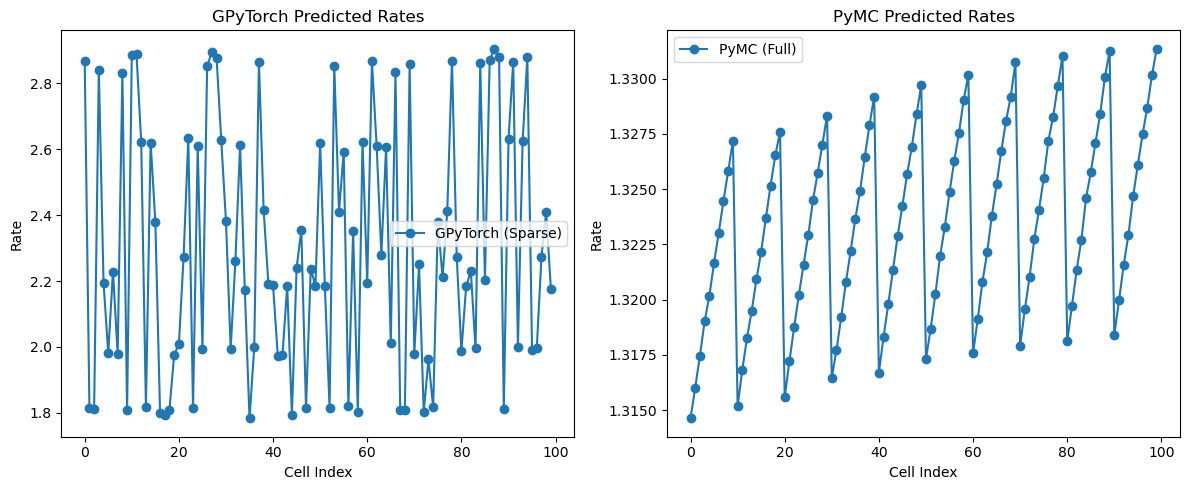

In [28]:
print(rate_pred)
print(np.exp(trace.posterior['log_intensity'].mean(dim=['chain', 'draw'])) * area_per_cell)

print(len(np.exp(trace.posterior['log_intensity'].mean(dim=['chain', 'draw'])) * area_per_cell))
print(len(rate_pred))

pymc_rates = np.exp(trace.posterior['log_intensity'].mean(dim=['chain', 'draw']).values) * area_per_cell
gpytorch_rates = rate_pred.numpy()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# GPyTorch
plt.subplot(1, 2, 1)
plt.plot(gpytorch_rates, 'o-', label='GPyTorch (Sparse)')
plt.title('GPyTorch Predicted Rates')
plt.xlabel('Cell Index')
plt.ylabel('Rate')
plt.legend()

# PyMC
plt.subplot(1, 2, 2)
plt.plot(pymc_rates, 'o-', label='PyMC (Full)')
plt.title('PyMC Predicted Rates')
plt.xlabel('Cell Index')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()

Output()

Finished [100%]: Average Loss = 245.27


Epoch 100/2000 - Loss: 1.779
Epoch 200/2000 - Loss: 1.756
Epoch 300/2000 - Loss: 1.753
Epoch 400/2000 - Loss: 1.752
Epoch 500/2000 - Loss: 1.752
Epoch 600/2000 - Loss: 1.752
Epoch 700/2000 - Loss: 1.752
Epoch 800/2000 - Loss: 1.752
Epoch 900/2000 - Loss: 1.752
Epoch 1000/2000 - Loss: 1.752
Epoch 1100/2000 - Loss: 1.752
Epoch 1200/2000 - Loss: 1.752
Epoch 1300/2000 - Loss: 1.752
Epoch 1400/2000 - Loss: 1.752
Epoch 1500/2000 - Loss: 1.752
Epoch 1600/2000 - Loss: 1.752
Epoch 1700/2000 - Loss: 1.752
Epoch 1800/2000 - Loss: 1.752
Epoch 1900/2000 - Loss: 1.752
Epoch 2000/2000 - Loss: 1.752


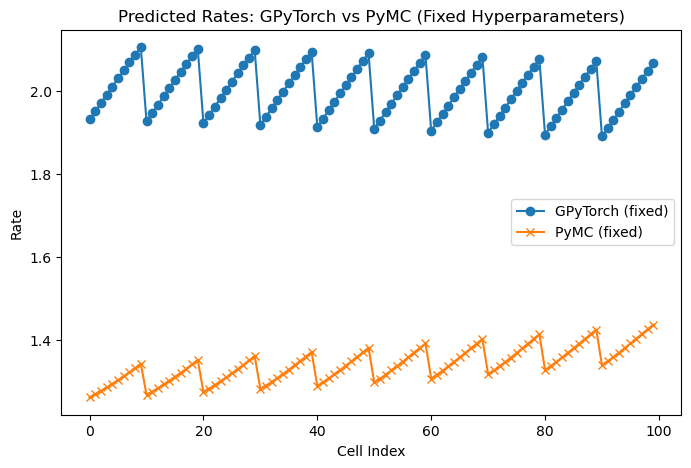

PyMC mean/std: 1.341279309852629 0.040286781512586876
GPyTorch mean/std: 1.9996347 0.05792553
Max abs diff: 0.7607368237621599


In [38]:
import numpy as np
import random
import torch

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Shared data
area_per_cell = 1.0
N = 100
centroids = np.array([(x, y) for x in range(10) for y in range(10)], dtype=np.float32)
cell_counts = np.random.poisson(2.0, N).astype(np.float32)  # Use Poisson for realism

# Shared hyperparameters (fixed, not learned)
mu_value = 0.0
rho_value = 50.0
variance_value = 1.0

import pymc as pm

with pm.Model() as lgcp_model:
    cov_func = variance_value * pm.gp.cov.Matern52(2, ls=rho_value)
    mu = pm.Normal("mu", mu_value, 3.0)  # Prior mean=0, std=3 (or your choice)
    mean_func = pm.gp.mean.Constant(mu)
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov_func)
    log_intensity = gp.prior("log_intensity", X=centroids)
    intensity = pm.math.exp(log_intensity)
    rates = intensity * area_per_cell
    counts = pm.Poisson("counts", mu=rates, observed=cell_counts)

    approx = pm.fit(n=2000, method='advi')
    trace = approx.sample(100)

# Posterior mean rate
pymc_rates = np.exp(trace.posterior['log_intensity'].mean(dim=['chain', 'draw']).values) * area_per_cell


import gpytorch

# Convert data to torch tensors
centroids_torch = torch.tensor(centroids, dtype=torch.float32)
cell_counts_torch = torch.tensor(cell_counts, dtype=torch.float32)

# Custom Poisson likelihood
class PoissonLikelihood(gpytorch.likelihoods._OneDimensionalLikelihood):
    def forward(self, function_samples, **kwargs):
        rate = torch.exp(function_samples) * area_per_cell
        return torch.distributions.Poisson(rate)

# Sparse GP model (all points as inducing points)
class SparseLGCPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(
            self, inducing_points, variational_distribution, learn_inducing_locations=False
        )
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)
        )
        # Set fixed hyperparameters
        self.mean_module.constant.data.fill_(mu_value)
        self.covar_module.base_kernel.lengthscale = rho_value
        self.covar_module.outputscale = variance_value
        # Freeze parameters
        # Only freeze kernel and mean parameters
        for name, param in self.named_parameters():
            if 'covar_module' in name: # 'mean_module' in name or 
                param.requires_grad = False

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

inducing_points = centroids_torch.clone()
model = SparseLGCPModel(inducing_points)
likelihood = PoissonLikelihood()

model.train()
likelihood.train()
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=centroids_torch.size(0))

num_epochs = 2000
for i in range(num_epochs):
    optimizer.zero_grad()
    output = model(centroids_torch)
    loss = -mll(output, cell_counts_torch)
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
        print(f"Epoch {i+1}/{num_epochs} - Loss: {loss.item():.3f}")
        

model.eval()
likelihood.eval()
with torch.no_grad():
    posterior = model(centroids_torch)
    gpytorch_rates = torch.exp(posterior.mean) * area_per_cell
    gpytorch_rates = gpytorch_rates.numpy()


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(gpytorch_rates, 'o-', label='GPyTorch (fixed)')
plt.plot(pymc_rates, 'x-', label='PyMC (fixed)')
plt.title('Predicted Rates: GPyTorch vs PyMC (Fixed Hyperparameters)')
plt.xlabel('Cell Index')
plt.ylabel('Rate')
plt.legend()
plt.show()

print("PyMC mean/std:", pymc_rates.mean(), pymc_rates.std())
print("GPyTorch mean/std:", gpytorch_rates.mean(), gpytorch_rates.std())
print("Max abs diff:", np.max(np.abs(pymc_rates - gpytorch_rates)))

In [37]:
print("PyMC learned mu:", trace.posterior['mu'].mean().values)
print("GPyTorch learned mu:", model.mean_module.constant.item())

PyMC learned mu: 0.2406206219844058
GPyTorch learned mu: 0.6443768739700317


# Interpreting the results

Posterior inference on the length_scale parameter is useful for understanding whether or not there are long-range correlations in the data. We can also examine the mean of the log-intensity field, but since it is on the log scale it is hard to directly interpret.

In [2]:
az.summary(trace, var_names=["mu", "rho"])

NameError: name 'az' is not defined

We are also interested in looking at the value of the intensity field at a large number of new points in space. We can accommodate this within our model by including a new random variable for the latent Gaussian process evaluated at a denser set of points. Using `sample_posterior_predictive`, we generate posterior predictions on new data points contained in the variable `intensity_new`.

In [66]:
x_new = np.linspace(5, 275, 20)
y_new = np.linspace(5, 175, 20)
xs, ys = np.asarray(np.meshgrid(x_new, y_new))
xy_new = np.asarray([xs.ravel(), ys.ravel()]).T

with lgcp_model:
    intensity_new = gp.conditional("log_intensity_new", Xnew=xy_new)

    spp_trace = pm.sample_posterior_predictive(
        trace, var_names=["log_intensity_new"], #keep_size=True
    )

trace.extend(spp_trace)


Sampling: [log_intensity_new]


Output()

Let's take a look at a few realizations of $\lambda(s)$. Since the samples are on the log scale, we'll need to exponentiate them to obtain the spatial intensity field of our 2D Poisson process. In the plot below, the observed point pattern is overlaid.

In [1]:
trace

NameError: name 'trace' is not defined

In [68]:
intensity_samples = np.exp(trace.posterior_predictive["log_intensity_new"])

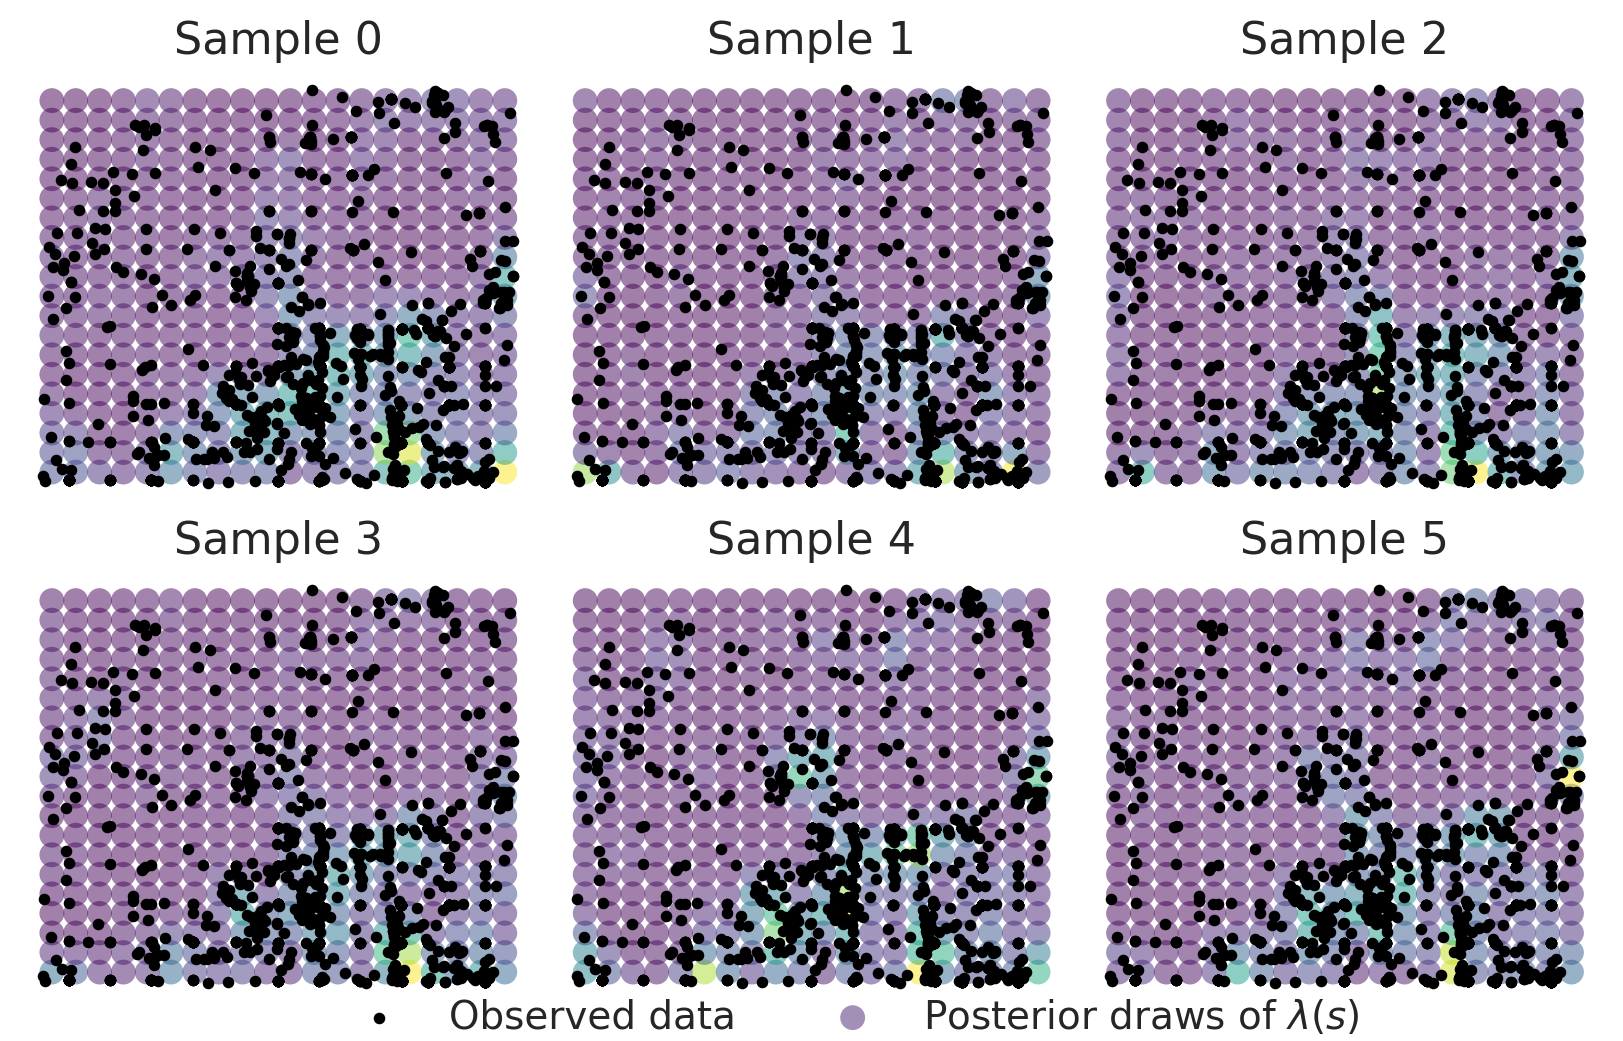

In [69]:
fig, axes = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
axes = axes.ravel()

field_kwargs = {"marker": "o", "edgecolor": "None", "alpha": 0.5, "s": 80}

for i in range(6):
    field_handle = axes[i].scatter(
        xy_new[:, 0], xy_new[:, 1], c=intensity_samples.sel(chain=0, draw=i), **field_kwargs
    )

    obs_handle = axes[i].scatter(data["x"], data["y"], s=10, color="k")
    axes[i].axis("off")
    axes[i].set_title(f"Sample {i}")

plt.figlegend(
    (obs_handle, field_handle),
    ("Observed data", r"Posterior draws of $\lambda(s)$"),
    ncol=2,
    loc=(0.2, -0.01),
    fontsize=14,
    frameon=False,
);

While there is some heterogeneity in the patterns these surfaces show, we obtain a posterior mean surface with a very clearly defined spatial surface with higher intensity in the upper right and lower intensity in the lower left.

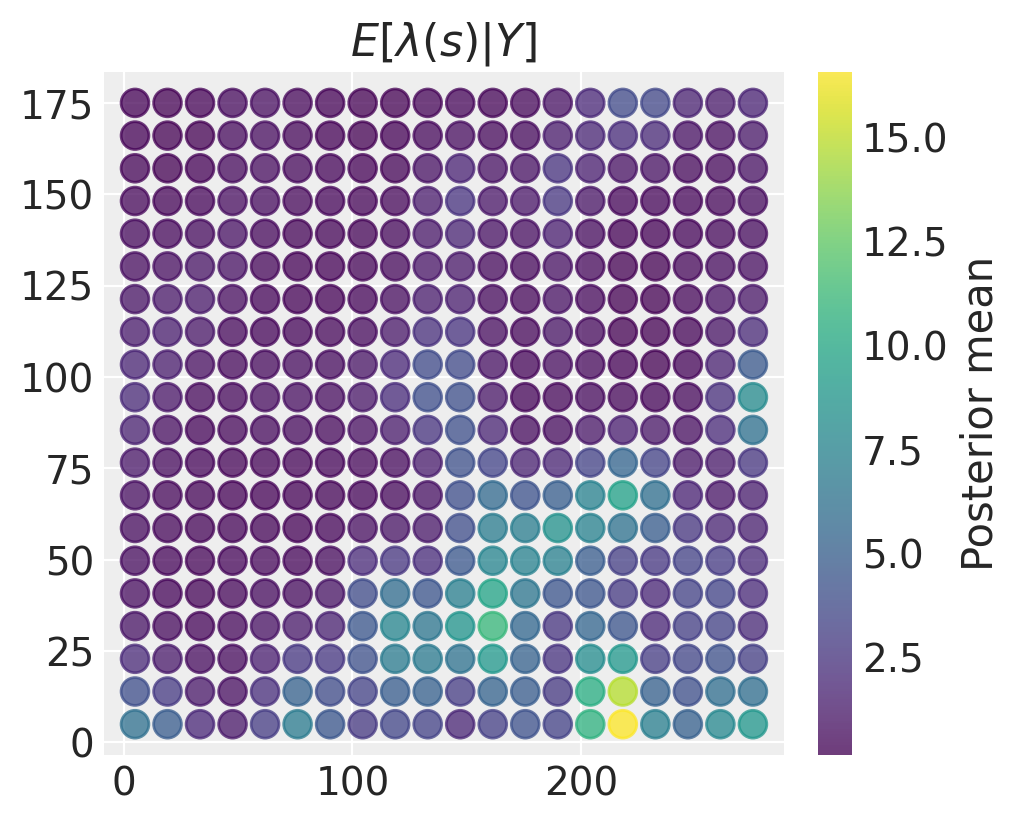

In [70]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.mean(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)

plt.title("$E[\\lambda(s) \\vert Y]$")
plt.colorbar(label="Posterior mean");

The spatial variation in our estimates of the intensity field may not be very meaningful if there is a lot of uncertainty. We can make a similar plot of the posterior variance (or standard deviation) in this case:

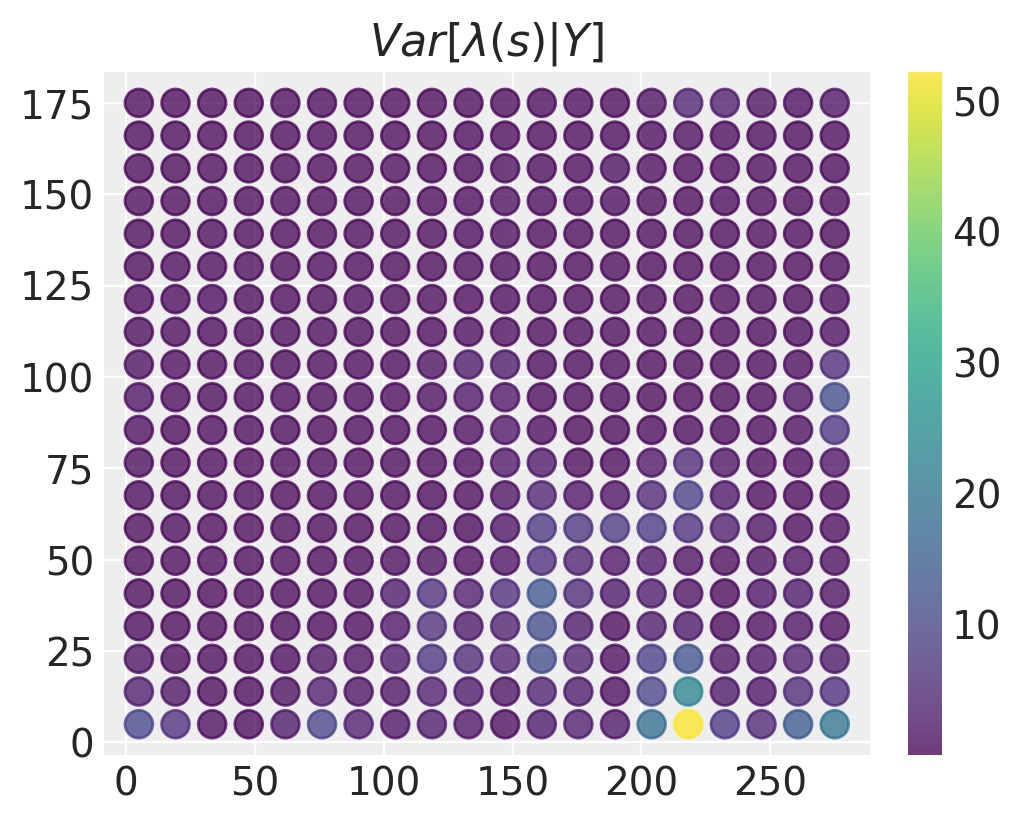

In [71]:
fig = plt.figure(figsize=(5, 4))

plt.scatter(
    xy_new[:, 0],
    xy_new[:, 1],
    c=intensity_samples.var(("chain", "draw")),
    marker="o",
    alpha=0.75,
    s=100,
    edgecolor=None,
)
plt.title("$Var[\\lambda(s) \\vert Y]$"), plt.colorbar();

The posterior variance is lowest in the middle of the domain and largest in the corners and edges. This makes sense - in locations where there is more data, we have more accurate estimates for what the values of the intensity field may be.

## Authors

- This notebook was written by [Christopher Krapu](https://github.com/ckrapu) on September 6, 2020 and updated on April 1, 2021.
- Updated by Chris Fonnesbeck on May 31, 2022 for v4 compatibility.

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Jun 01 2022

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.1.1

matplotlib: 3.5.1
arviz     : 0.12.0
numpy     : 1.22.2
pymc      : 4.0.0b6
pandas    : 1.4.1
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:24:11) 
[GCC 9.4.0]

Watermark: 2.3.0



:::{include} ../page_footer.md
:::